In this notebook I am analyzing the response time of each call. I am considering only response time >0 (from UM sending a request to receiving a reply). This is what I found out:

Mean response time per call (ms):  10.598351070199756  standard deviation (ms):  63.343039747865355

Median response time per call (ms):  1.0

However, it is important to say that response times <0 have been recorded as 0

In [1]:
import tarfile
import pandas as pd
import numpy as np
import os
from statistics import mean,median,stdev
import matplotlib.pyplot as plt

In [4]:
rt_df = pd.DataFrame(columns=['rt'])
rt_df

,rt


In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm


import contextlib
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()
        
def extract_rt(i):
    to_skip = tuple([2,57,60,64,66,75,98,101,125,129,130,144]) # corrupted files
    if to_skip.count(i) > 0:
        return []
    # open file
    file = tarfile.open(f'MSCallGraph_{i}.tar.gz')

    # extracting file
    file.extractall('./')

    file.close()
    df = pd.read_csv(f'MSCallGraph_{i}.csv')
    df=df.drop(['Unnamed: 0','timestamp','rpcid','interface','um','dm','rpctype','traceid'],axis=1)
    df = df.replace('(?)', np.NaN)
    df = df.replace('', np.NaN)
    df = df.replace('NAN', np.NaN)
    df = df.dropna()
    df = df[df['rt']>=0]
    
    lista = list(df['rt'])
    
    os.remove(f'MSCallGraph_{i}.csv')
    return lista

with tqdm_joblib(tqdm(desc="RT Analysis", total=145)) as progress_bar:
    results = Parallel(n_jobs=-1)(delayed(extract_rt)(i) for i in range(0, 145))
    for rt in results:
        temp = pd.DataFrame(rt,columns=['rt'])
        rt_df =  pd.concat([rt_df,temp])


RT Analysis:  82%|████████▏ | 119/145 [18:16<04:54, 11.33s/it]C:\Users\gianl\anaconda3\envs\MasterThesis\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
RT Analysis: 100%|██████████| 145/145 [21:36<00:00,  7.05s/it]

In [ ]:
# rt_df = pd.DataFrame(rt_list,columns=['rt'])
rt_df

In [ ]:
# rt_df.to_csv('MSCallGraph_rt.csv',index=False)

In [9]:
rt_df = pd.read_csv('MSCallGraph_rt.csv')
rt_df

,rt
0,0
1,1
2,1
3,1
4,1
...,...
742496613,1
742496614,1
742496615,1
742496616,0


In [10]:
rt_df.mean()

rt    10.598351
dtype: float64

In [11]:
rt_list = list(rt_df['rt'])

In [12]:
print("Mean response time per call (ms): ", mean(rt_list), " standard deviation (ms): ", stdev(rt_list))
print("Median response time per call (ms): ", median(rt_list))

Mean response time per call (ms):  10.598351070199756  standard deviation (ms):  63.343039747865355
Median response time per call (ms):  1.0


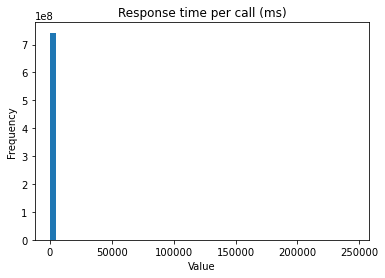

In [13]:
plt.hist(rt_list,bins=50)
# Set the labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Response time per call (ms)')

# Show the plot
plt.show()

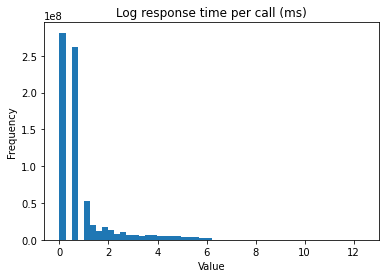

In [14]:
plt.hist(np.log(np.array(rt_list)+1),bins=50)
# Set the labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log response time per call (ms)')

# Show the plot
plt.show()

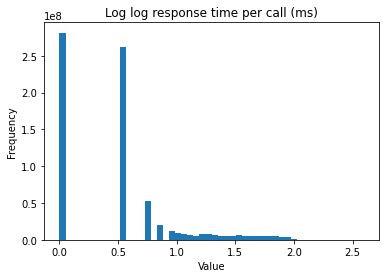

In [15]:
plt.hist(np.log(np.log(np.array(rt_list)+1)+1),bins=50)
# Set the labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log log response time per call (ms)')

# Show the plot
plt.show()